In [1]:
print("Starting run...")

Starting run...


In [2]:
#@title import packages
import re
import dotenv
import torch
from tqdm import tqdm
#from google.colab import drive, files
import pandas as pd
import json
import sys
import numpy as np
import os
#from google.colab import userdata
import glob


In [3]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level="DEBUG")

In [4]:
from src import data

from src.data import load_relation_dict, load_dataset, RelationDataset
from tempfile import NamedTemporaryFile
import json


json_file = "../../data/anon-2024/has_color.json"
with open(json_file) as f:
    relation_json = json.load(f)

if "prompt_templates_zs" not in relation_json:
    relation_json["prompt_templates_zs"] = relation_json["prompt_templates"]

dataset_orig = data.load_dataset()

with NamedTemporaryFile(suffix=".json", mode="w") as f:
    json.dump(relation_json, f)
    f.flush()
    dataset_new = load_dataset(f.name)

dataset = RelationDataset(dataset_orig.relations + dataset_new.relations)

DEBUG:src.data:no paths provided, using default data dir: /workspace/data
DEBUG:src.data:/workspace/data is directory, globbing for json files...
DEBUG:src.data:found relation file: /workspace/data/anon-2024/has_color.json
DEBUG:src.data:found relation file: /workspace/data/bias/characteristic_gender.json
DEBUG:src.data:found relation file: /workspace/data/bias/degree_gender.json
DEBUG:src.data:found relation file: /workspace/data/bias/name_birthplace.json
DEBUG:src.data:found relation file: /workspace/data/bias/name_gender.json
DEBUG:src.data:found relation file: /workspace/data/bias/name_religion.json
DEBUG:src.data:found relation file: /workspace/data/bias/occupation_age.json
DEBUG:src.data:found relation file: /workspace/data/bias/occupation_gender.json
DEBUG:src.data:found relation file: /workspace/data/commonsense/fruit_inside_color.json
DEBUG:src.data:found relation file: /workspace/data/commonsense/fruit_outside_color.json
DEBUG:src.data:found relation file: /workspace/data/com

In [5]:
#@title set paths
sys.path.append('/content/drive/Shareddrives/MoralLearning/RelationalComposition/')
dotenv.load_dotenv('vars.env')
root_path = '/content/drive/Shareddrives/MoralLearning/RelationalComposition/'
repo_path = f'{root_path}relations/'
sys.path.append(repo_path)
sys.path.append(repo_path+'/src/')
data_path = f'{root_path}data/'

In [6]:
#@title load local packages
from src import data
from src.data import load_relation_dict, load_dataset, RelationDataset
from tempfile import NamedTemporaryFile



In [7]:
# Load datafiles
import torch
import glob
import os
metadata_path = "/workspace/metadata/with-examples/*color*.pt"
all_metadata = {}
for metadata_file in glob.glob(metadata_path):
    print(f"Loading {os.path.basename(metadata_file)}")
    relation_to_metadata = torch.load(
        metadata_file,
        map_location=torch.device('cpu'),
    )
    all_metadata.update(relation_to_metadata)
# The keys are the name of the relationship class
all_metadata.keys()


Loading has_color_metadata.pt


dict_keys(['has_color', 'commit_hash'])

In [8]:
#@title define some functions & classes
from typing import List, Dict
from torch import Tensor
from src.data import RelationSample
import numpy as np
from dataclasses import dataclass
import seaborn as sns
import matplotlib.pyplot as plt
from functools import cached_property
from numpy import typing as npt
from src.utils import experiment_utils
from concurrent.futures import ProcessPoolExecutor

from typing import TypedDict

FAITHFULNESS_LEVEL = 2


class SubjectFaithfulnessMetadata(TypedDict):
    prediction_subject: str
    """Subject of the prediction."""

    faithfulness: List[float]
    """Faithfulness of the prediction."""


class FaithfulnessMetadata(TypedDict):
    faithfulness: List[float]
    """Overall faithfulness."""

    subject: str
    """Subject of the faithfulness."""

    subject_faithfulness: List[SubjectFaithfulnessMetadata]
    """Faithfulness of each subject."""



@dataclass(frozen=True, kw_only=True)
class SampleMetadata:
    """Metadata for a sample."""
    label: str
    """The label of the sample."""

    metadata: Dict[str, Tensor]
    """Contains all of the metadata for the sample."""

    @cached_property
    def weight(self) -> npt.NDArray[np.float16]:
        """Return the weights of the sample.

        This is the weight matrix of the sample, which is
        called ``W`` in the paper.
        """
        assert len(self.metadata['weights']) == 1, \
            f"Weights should have one element, got {len(self.metadata['weights'])}"
        return self.metadata['weights'][0].numpy(force=True)

    @cached_property
    def z(self) -> npt.NDArray[np.float16]:
        """Return the ``z`` values of the sample.

        This corresponds to the un-normalized output of the encoder,
        and is the latent representation of the object, which is
        called ``o`` in the paper.
        """
        assert len(self.metadata['zs']) == 1, \
            f"z should have one element, got {len(self.metadata['zs'])}"

        return self.metadata['zs'][0].numpy(force=True)

    @cached_property
    def h(self) -> npt.NDArray[np.float16]:
        """Return the ``h`` values of the sample.

        This is the hidden layer values of the sample, which is
        called ``s`` in the paper.
        """
        assert len(self.metadata['hs']) == 1, \
            f"h should have one element, got {len(self.metadata['hs'])}"
        return self.metadata['hs'][0].numpy(force=True)

    @property
    def faithfulness(self) -> npt.NDArray[float]:
        """Return the faithfulness of the sample.

        Each element of the sequence is the faithfulness after
        "k" guesses, i.e., the first element is the faithfulness
        after 1 guess, the second element is the faithfulness
        after 2 guesses, etc.

        Note that this if multiple guesses are considered correct, it
        possible for the faithfulness here to be > 1.0. For example,

            a toad is in the class of {amph, amphibian}

        counts as two different correct answers. In this case, we want
        to give credit to models that are "more correct".
        """
        assert 'faithfulness' in self.metadata, \
            f"Faithfulness should be in the metadata, got {self.metadata.keys()}"
        return np.array(self.metadata['faithfulness']['faithfulness'])

    @property
    def faithfulness_metadata(self) -> FaithfulnessMetadata:
        """Return the faithfulness metadata of the sample."""
        assert 'faithfulness' in self.metadata, \
            f"Faithfulness should be in the metadata, got {self.metadata.keys()}"
        return self.metadata['faithfulness']

dist_function = lambda X, Y: np.sqrt(((X-Y).astype(np.float32)**2).sum())

# Function to calculate distance between weights[i] and weights[j]
def calc_distance_pair(args):
    i, j, weights_i, weights_j = args
    return i, j, dist_function(weights_i, weights_j)

@dataclass(frozen=True, kw_only=True)
class RelationMetadata:
    """Metadata for a relation."""

    relation: RelationSample
    metadata: List[Dict[str, Tensor]]

    @property
    def name(self):
        """Return the name of the relation."""
        return self.relation.name

    @property
    def labels(self) -> List[str]:
        """Return the labels of the samples."""
        return [str(s) for s in self.relation.samples]

    @property
    def weights(self) -> List[npt.NDArray]:
        """Return the weights of the samples."""
        return [m.weight for m in self.samples]

    @cached_property
    def samples(self) -> List[RelationSample]:
        """Return the relation samples."""
        assert len(self.relation.samples) == len(self.metadata), \
            f"Samples and metadata must be the same length, got " \
            f"{len(self.relation.samples)} and {len(self.metadata)}"
        return [
            SampleMetadata(
                label=str(s),
                metadata=m,
            )
            for s, m in zip(self.relation.samples, self.metadata)
        ]


    @cached_property
    def w_dists(self) -> npt.NDArray[np.float32]:
        """Compute the distance matrix of the weights."""
        num_labels = len(self.labels)
        dists = np.zeros((num_labels, num_labels))


        # Create all pairs (i, j) where i < j
        pairs = [(i, j, self.weights[i], self.weights[j]) for i in range(num_labels) for j in range(i+1, num_labels)]

        # Process pairs in parallel
        with ProcessPoolExecutor(max_workers=8) as executor:
            results = executor.map(calc_distance_pair, pairs)

        # Fill the symmetric matrix
        for i, j, dist in results:
            dists[i, j] = dist
            dists[j, i] = dist
        return dists

    @cached_property
    def _w_dists_old(self):
        """Return the distance function."""
        labels = self.labels
        weights = self.weights
        assert len(weights) == len(labels), f"Weights and labels must be the same length, got {len(weights)} and {len(labels)}"
        # Create a square matrix of the distances
        dists = np.zeros((len(labels), len(labels)))
        for i in range(len(labels)):
            for j in range(len(labels)):
                if i >= j:
                    continue
                dists[i, j] = dist_function(weights[i], weights[j])
                dists[j, i] = dists[i, j]
        return dists

    @cached_property
    def o_dists(self) -> npt.NDArray[np.float32]:
        """Compute the distance matrix of the object (z) activations."""
        labels = self.labels
        all_sz = [s.z for s in self.samples]
        assert len(all_sz) == len(labels), f"Weights and labels must be the same length, got {len(all_sz)} and {len(labels)}"
        dist_function = lambda X, Y: np.sqrt(((X-Y).astype(np.float32)**2).sum())
        # Create a square matrix of the distances
        dists = np.zeros((len(labels), len(labels)))
        for i in range(len(labels)):
            for j in range(len(labels)):
                if i >= j:
                    continue
                dists[i, j] = dist_function(all_sz[i], all_sz[j])
                dists[j, i] = dists[i, j]
        return dists

    @cached_property
    def s_dists(self) -> npt.NDArray[np.float32]:
        """Compute the distance matrix of the subject (h) activations."""
        labels = self.labels
        all_sz = [s.h for s in self.samples]
        assert len(all_sz) == len(labels), f"Weights and labels must be the same length, got {len(all_sz)} and {len(labels)}"
        dist_function = lambda X, Y: np.sqrt(((X-Y).astype(np.float32)**2).sum())
        # Create a square matrix of the distances
        dists = np.zeros((len(labels), len(labels)))
        for i in range(len(labels)):
            for j in range(len(labels)):
                if i >= j:
                    continue
                dists[i, j] = dist_function(all_sz[i], all_sz[j])
                dists[j, i] = dists[i, j]
        return dists

    @cached_property
    def faithfulness_dists(self) -> npt.NDArray[np.float32]:
        """Compute the distance matrix of the faithfulness."""
        labels = self.labels
        label_to_subject = {}
        for l, s in zip(labels, self.samples):
            subject = s.faithfulness_metadata["subject"]
            assert l.startswith(subject), \
                f"Label {l} does not start with {subject}"
            label_to_subject[l] = subject


        # Create a square matrix of the distances
        dists = np.zeros((len(labels), len(labels)))
        for i in range(len(labels)):
            i_label = labels[i]
            for j in range(len(labels)):
                # Not symmetric
                if i == j:
                    continue
                j_label = labels[j]
                j_subject = label_to_subject[j_label]

                faithfulness = self.samples[i].faithfulness_metadata["subject_faithfulness"]

                index = None
                for index, j_subject_metadata in enumerate(faithfulness):
                    if j_subject_metadata["prediction_subject"] == j_subject:
                        break
                assert index is not None, \
                    f"Could not find {j_subject} in {faithfulness} (subject {i_label})"
                dists[i, j] = faithfulness[index]["faithfulness"][FAITHFULNESS_LEVEL] * 5
        return dists


    def plot_w_dists(self):
        """Plot the dists between the weight matrices."""
        sns.set_theme(style="white")

        corr = self.w_dists
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))

        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)

        # Draw the heatmap with the mask and correct aspect ratio
        ax = sns.heatmap(
            corr,
            mask=mask,
            cmap=cmap,
            vmin=0,
            xticklabels=self.labels,
            yticklabels=self.labels,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
        )
        ax.set_title(self.name)


    @classmethod
    def from_metadata(
        cls,
        relation: RelationSample,
        metadata: List[Dict[str, Tensor]],
    ) -> "RelationMetadata":
        """Create a relation metadata object from a list of metadata."""
        return cls(
            relation=relation,
            metadata=metadata,
        )


DEBUG:matplotlib:matplotlib data path: /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/mccoy/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:CACHEDIR=/home/mccoy/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/mccoy/.cache/matplotlib/fontlist-v330.json


In [9]:
#load all relation metadata
data_outputs = {}

for relation in dataset.relations:
    # WARNING: This is extremely fragile, but we need to generate the
    # examples and test in the same way as in the original notebook.
    experiment_utils.set_seed(12345) # set seed to a constant value for sampling consistency
    examples, test_relation = relation.split(3)

    if relation.name not in all_metadata:
        #print(f"No metadata for {relation.name}")
        continue

    print(relation.name)
    relation_metadata = RelationMetadata.from_metadata(
        relation=test_relation,
        metadata=all_metadata[relation.name],
    )
    #print([s.faithfulness_metadata for s in relation_metadata.samples[:1]])
    #print(relation_metadata.faithfulness_dists)
    for sample in relation_metadata.samples:
        pass
        #print(f"{sample.label} W: {sample.weight.shape}")
        #print(f"{sample.label} o: {sample.z.shape}")
        #print(f"{sample.label} s: {sample.h.shape}")
    #relation_metadata.plot_w_dists()
    plt.show()
    print()
    data_outputs[relation.name] = relation_metadata

INFO:src.utils.experiment_utils:setting all seeds to 12345
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setting all seeds to 12345
INFO:src.utils.experiment_utils:setti

has_color

has_color



In [10]:
#we now focus on just the has_color dataset
relation_metadata = data_outputs["has_color"]

In [11]:
#get the W distances
w=relation_metadata.w_dists
labels=relation_metadata.labels
#get the object (z) distances
o=relation_metadata.o_dists
#get the subject (h) distances
s=relation_metadata.s_dists

f = relation_metadata.faithfulness_dists

# assert w.shape==s.shape
# assert w.shape==o.shape
# assert len(labels)==w.shape[0]

In [12]:
np.savetxt(metadata_path+'w.csv', w, delimiter=',', fmt='%d')

In [13]:
labels

['celery -> green',
 'a flamingo -> pink',
 'a canary -> yellow',
 'a panther -> black ',
 'a barrel -> brown',
 'a stone -> grey',
 'a goat -> white',
 'a spoon -> silver',
 'a crow -> black',
 'a mandarin -> orange',
 'a plum -> purple',
 'a wagon -> red',
 'a trumpet -> gold',
 'a turtle -> green',
 'a pineapple -> yellow',
 'a beaver -> brown',
 'a toilet -> white',
 'a pumpkin -> orange',
 'a fox -> red',
 'a zucchini -> green',
 'corn -> yellow',
 'a dove -> white',
 'a carrot -> orange',
 'a cranberry -> red',
 'broccoli -> green',
 'a lemon -> yellow',
 'a cauliflower -> white',
 'a cherry -> red',
 'a frog -> green',
 'a bathtub -> white',
 'a brick -> red',
 'a crocodile -> green',
 'a raspberry -> red',
 'a lime -> green',
 'a tomato -> red',
 'an emerald -> green',
 'a strawberry -> red',
 'a cucumber -> green',
 'spinach -> green',
 'lettuce -> green',
 'asparagus -> green']

In [14]:
#mask all of the matrices
# generate a mask for the upper triangle
mask = np.triu(np.ones_like(w, dtype=bool))
mask_outlier = w<1
w_masked = w[~mask & ~mask_outlier]
s_masked = s[~mask & ~mask_outlier]
o_masked = o[~mask & ~mask_outlier]
f_masked = f[~mask & ~mask_outlier]
print(w_masked.shape)
print(s_masked.shape)
print(o_masked.shape)
print(f_masked.shape)

(820,)
(820,)
(820,)
(820,)


In [15]:
#correlate s and w, and o and w
result_corr=np.corrcoef(x=s_masked, y=w_masked)
print('correlation between s matrix and w: %.3f' % result_corr[0,1])


result_corr=np.corrcoef(x=o_masked, y=w_masked)
print('correlation between o matrix and w: %.3f' % result_corr[0,1])


correlation between s matrix and w: 0.392
correlation between o matrix and w: 0.723


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/lo

Text(0.5, 1.0, 'Object Activation Distance vs Weight Activation Distance')

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/lo

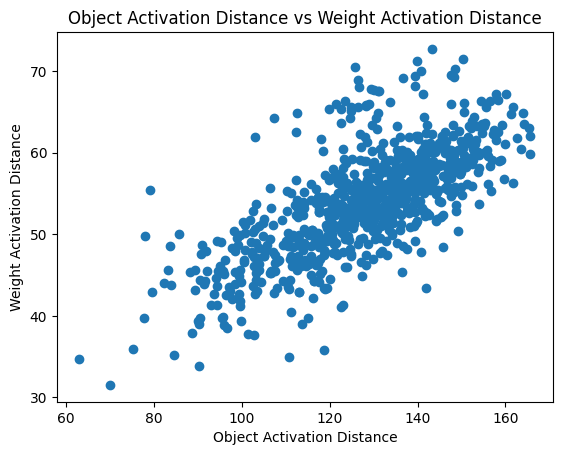

In [16]:
#create scatterplot
plt.scatter(o_masked, w_masked)
plt.xlabel("Object Activation Distance")
plt.ylabel("Weight Activation Distance")
plt.title("Object Activation Distance vs Weight Activation Distance")

Text(0.5, 1.0, 'Faithfulness Distance vs Weight Activation Distance')

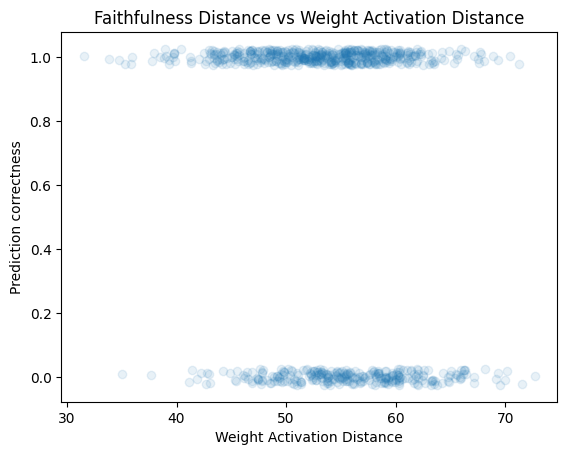

In [17]:
# Jitter
jitter = (np.random.random(len(f_masked)) -0.5) * 0.05
plt.scatter(w_masked, f_masked + jitter, alpha=0.1)
plt.ylabel("Prediction correctness")
plt.xlabel("Weight Activation Distance")
plt.title("Faithfulness Distance vs Weight Activation Distance")

Text(0.5, 1.0, 'Subject Activation Distance vs Weight Activation Distance')

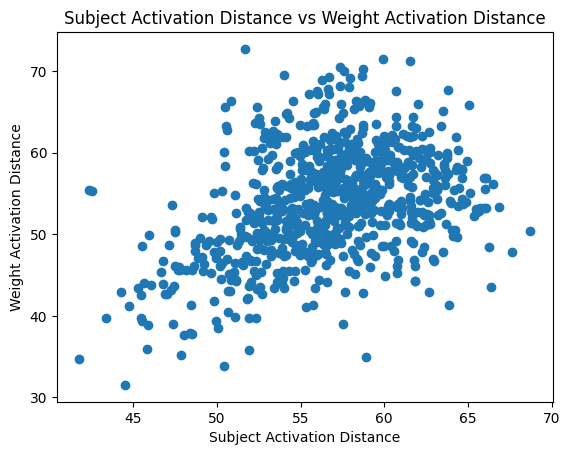

In [18]:
#create scatterplot
plt.scatter(s_masked, w_masked)
plt.xlabel("Subject Activation Distance")
plt.ylabel("Weight Activation Distance")
plt.title("Subject Activation Distance vs Weight Activation Distance")

Text(0.5, 1.0, 'Distance Distributions')

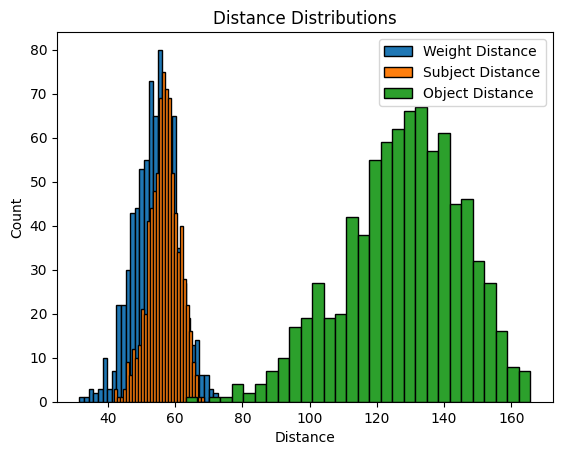

In [19]:

plt.hist(w_masked, bins=30, edgecolor='black', label="Weight Distance")
plt.hist(s_masked, bins=30, edgecolor='black', label="Subject Distance")
plt.hist(o_masked, bins=30, edgecolor='black', label="Object Distance")
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Distance Distributions")

In [20]:
#import linear model functions

import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [21]:
#@title load uncertainty data files for analyis - only for has_color dataset
#1. read uncertainties data from drive, convert to dataframe
filepath = "/workspace/metadata/results_uncertainties.json"
with open(filepath, 'r') as fp:
    uncertainties = json.load(fp)


In [22]:
def parse_label(label):
    #take the label and split it by ->
    ss=label.split(' -> ')
    return ss[0]

def split_labels(labels):
    split_labels = []
    for l in labels:
        ss=l.split()
        if(len(ss)>1):
            split_labels.append(ss[1])
        else:
            split_labels.append(ss[0])
    return split_labels

In [23]:
#get labels into common form to match/align them
metadata_labels = split_labels([parse_label(x) for x in relation_metadata.labels])
uncertainty_labels = split_labels(uncertainties.keys())

#rename uncertainty data with the new labels
uncertainties_relabeled = dict(zip(uncertainty_labels, uncertainties.values()))

#create a mask for those items in metadata that exist in uncertainties
match_mask=[True if x in uncertainty_labels else False for x in metadata_labels]

#return the matching labels as well, in same order
included_labels = [x for i,x in enumerate(metadata_labels) if match_mask[i]]

#select the data for which we have matching labels
w_filtered = w[np.ix_(match_mask, match_mask)]
s_filtered = s[np.ix_(match_mask, match_mask)]
o_filtered = o[np.ix_(match_mask, match_mask)]
f_filtered = f[np.ix_(match_mask, match_mask)]


#pull out uncertainties in the same order as the list included_labels
uncertainties_reordered =  [np.mean(uncertainties_relabeled[x]) for x in included_labels]

print('found %d matches' % sum(match_mask))
# len(metadata_labels)
# len(matching_indices)


found 41 matches


In [24]:
#create data subsets - high accuracy data vs low accuracy data

#split data into high accuracy vs low accuracy / high uncertainty.
high_acc_filt =[True if x >.70 else False for x in uncertainties_reordered ]
low_acc_filt = ~(np.array(high_acc_filt))
print(sum(high_acc_filt))
print(sum(low_acc_filt))
w_filtered_high_acc = w_filtered[np.ix_(high_acc_filt,high_acc_filt)]
s_filtered_high_acc = s_filtered[np.ix_(high_acc_filt,high_acc_filt)]
w_filtered_low_acc = w_filtered[np.ix_(low_acc_filt,low_acc_filt)]
s_filtered_low_acc = s_filtered[np.ix_(low_acc_filt,low_acc_filt)]


27
14


In [25]:
#display item labels in the two categories
high_acc_labels = [included_labels[x] for x in range(len(included_labels))if high_acc_filt[x]]
print(high_acc_labels)
low_acc_labels = [included_labels[x] for x in range(len(included_labels))if low_acc_filt[x]]
print(low_acc_labels)

['celery', 'flamingo', 'canary', 'goat', 'crow', 'beaver', 'toilet', 'pumpkin', 'zucchini', 'dove', 'carrot', 'cranberry', 'broccoli', 'lemon', 'cherry', 'frog', 'bathtub', 'crocodile', 'raspberry', 'lime', 'tomato', 'emerald', 'strawberry', 'cucumber', 'spinach', 'lettuce', 'asparagus']
['panther', 'barrel', 'stone', 'spoon', 'mandarin', 'plum', 'wagon', 'trumpet', 'turtle', 'pineapple', 'fox', 'corn', 'cauliflower', 'brick']


In [26]:
#create masked data for high & low accuracy items separately
mask_outlier = w_filtered_high_acc<1
mask_upper = np.triu(np.ones_like(w_filtered_high_acc, dtype=bool))
w_masked_high_acc = w_filtered_high_acc[~mask_upper & ~mask_outlier]
s_masked_high_acc = s_filtered_high_acc[~mask_upper & ~mask_outlier]
print(len(w_masked_high_acc))
print(len(s_masked_high_acc))


mask_outlier = w_filtered_low_acc<1
mask_upper = np.triu(np.ones_like(w_filtered_low_acc, dtype=bool))
w_masked_low_acc = w_filtered_low_acc[~mask_upper & ~mask_outlier]
s_masked_low_acc = s_filtered_low_acc[~mask_upper & ~mask_outlier]
print(len(w_masked_low_acc))
print(len(s_masked_low_acc))

351
351
91
91


In [27]:

import scipy.stats as stats
stats.ttest_ind(w_masked_high_acc, w_masked_low_acc)


TtestResult(statistic=-3.1642423015042356, pvalue=0.0016627089511888663, df=440.0)

In [28]:
#get average pair uncertainty and use as a predictor
#we want a distance matrix shape with the uncertainties that just averages the pair uncertainty for each pair

uncertainty_matrix = np.array(np.zeros((len(uncertainties_reordered),len(uncertainties_reordered))))

for i in range(len(uncertainties_reordered)):
    for j in range(len(uncertainties_reordered)):
        # print(i)
        # print(j)
        uncertainty_matrix[i,j] = np.mean([uncertainties_reordered[i], uncertainties_reordered[j]])



In [29]:
#all w's, masked
mask_outlier = w_filtered<1
mask_upper = np.triu(np.ones_like(w_filtered, dtype=bool))
w_filtered_masked = w_filtered[~mask_upper & ~mask_outlier]
s_filtered_masked = s_filtered[~mask_upper & ~mask_outlier]
o_filtered_masked = o_filtered[~mask_upper & ~mask_outlier]
f_filtered_masked = f_filtered[~mask_upper & ~mask_outlier]
u_filtered_masked = uncertainty_matrix[~mask_upper & ~mask_outlier]
print(len(w_filtered_masked))
print(len(s_filtered_masked))
print(len(u_filtered_masked))
print(len(f_filtered_masked))

820
820
820
820


It seems like s, o, and u each contribute significantly when added individually to the model.  Things start to get weird when they are added interactively, perhaps because of colinearity?

In [30]:
#average pair uncertainty as a predictor by itself

data_d = {
    'w': w_filtered_masked,
    's': s_filtered_masked,
    'u': u_filtered_masked,
    'o': o_filtered_masked,
    "f": f_filtered_masked,
}
data_df = pd.DataFrame(data_d)
# print(data_df)
#run linear model
results = smf.ols('w ~ u', data=data_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     22.46
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           2.53e-06
Time:                        20:30:02   Log-Likelihood:                -2694.2
No. Observations:                 820   AIC:                             5392.
Df Residuals:                     818   BIC:                             5402.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     56.8466      0.632     89.880      0.0

In [31]:
result = smf.logit('f ~ w ', data=data_df).fit()
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.628418
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      f   No. Observations:                  820
Model:                          Logit   Df Residuals:                      818
Method:                           MLE   Df Model:                            1
Date:                Wed, 30 Oct 2024   Pseudo R-squ.:                 0.03273
Time:                        20:30:02   Log-Likelihood:                -515.30
converged:                       True   LL-Null:                       -532.74
Covariance Type:            nonrobust   LLR p-value:                 3.519e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3336      0.663      6.532      0.000       3.033       5.634
w             -0.0685      0.

[0. 1.]
[[1. 0.]
 [1. 1.]]


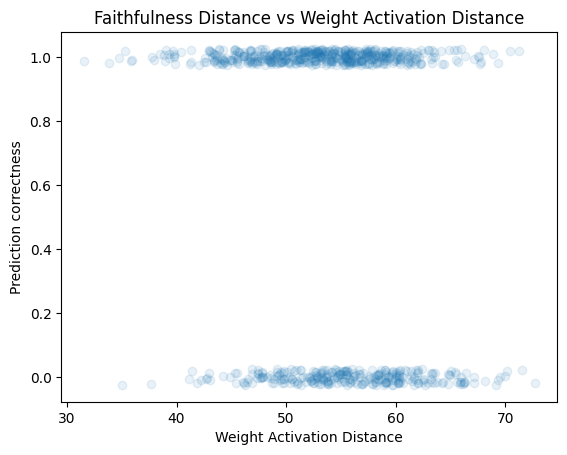

In [32]:
jitter = (np.random.random(len(f_masked)) -0.5) * 0.05
plt.scatter(w_masked, f_masked + jitter, alpha=0.1)
plt.ylabel("Prediction correctness")
plt.xlabel("Weight Activation Distance")
plt.title("Faithfulness Distance vs Weight Activation Distance")

# Data for plotting fitted values
x_plot = np.linspace(0, 1, 2)
print(x_plot)
# Add constant for the intercept
X_plot = sm.add_constant(x_plot)
print(X_plot)
# Calculate the predicted probabilities
#y_plot = result.predict(X_plot)
#print(y_plot)


In [33]:
#use average pair uncertainty as a predictor in combination with the S and O distance matrices

data_d = {'w': w_filtered_masked, 's': s_filtered_masked, 'u': u_filtered_masked, 'o': o_filtered_masked}
data_df = pd.DataFrame(data_d)
# print(data_df)
#run linear model
results = smf.ols('w ~ s + o + u', data=data_df).fit()
print(results.summary())

results = smf.ols('w ~ s * o * u', data=data_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     311.8
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          7.67e-135
Time:                        20:30:02   Log-Likelihood:                -2392.2
No. Observations:                 820   AIC:                             4792.
Df Residuals:                     816   BIC:                             4811.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.1632      2.046      7.410      0.0

In [34]:
#create pandas df
data_d = {'w': w_masked, 'o': o_masked, 's': s_masked}
data_df = pd.DataFrame(data_d)
# print(data_df)
#run linear model
print('Linear model predicting W from O and S')
results = smf.ols('w ~ o * s', data=data_df).fit()
print(results.summary())

Linear model predicting W from O and S
                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     307.5
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.63e-133
Time:                        20:30:02   Log-Likelihood:                -2395.2
No. Observations:                 820   AIC:                             4798.
Df Residuals:                     816   BIC:                             4817.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

Model W as a function of S (the subject representation). We see a significant predictive relationship!

In [35]:
#create pandas df
data_d = {'w': w_masked, 's': s_masked}
data_df = pd.DataFrame(data_d)
#run linear model
print('Linear model predicting W from S')
results = smf.ols('w ~ s', data=data_df).fit()
print(results.summary())


Linear model predicting W from S
                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     148.3
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           1.77e-31
Time:                        20:30:03   Log-Likelihood:                -2637.0
No. Observations:                 820   AIC:                             5278.
Df Residuals:                     818   BIC:                             5287.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.62

Compare W between high and low accuracy items. We predict that W distances should be greater when there is larger uncertainty (low > high). And this is what we see!

In [36]:
#create pandas df
data_d = {'w': w_masked, 'o': o_masked}
data_df = pd.DataFrame(data_d)
# print(data_df)
#run linear model
print('Linear model predicting W from O')
results = smf.ols('w ~ o', data=data_df).fit()
print(results.summary())

Linear model predicting W from O
                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     896.3
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.43e-133
Time:                        20:30:03   Log-Likelihood:                -2401.9
No. Observations:                 820   AIC:                             4808.
Df Residuals:                     818   BIC:                             4817.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.30